In [53]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import imageio

In [2]:
all_labels = pd.read_csv('../data/train_labels_all.csv')

In [3]:
# Get the id's of the files we sampled
sampled_images = os.listdir('../data/train_sample/')

In [4]:
filtered_data = all_labels[all_labels.ImageId.isin(sampled_images)]

In [6]:
filtered_data.head()

,ImageId,EncodedPixels
18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
19,0002756f7.jpg,248878 1 249645 4 250413 6 251180 9 251948 10 ...
84,0016ae695.jpg,NaN
92,00189cc36.jpg,NaN
100,001a7cba8.jpg,NaN


In [62]:
def code2image(encoding, input_image):
    if pd.isnull(encoding):
        return input_image
    
    else:
        split_encoding = encoding.split()
        n_pixels = int(len(split_encoding)/2)
        
        # pixels are 1 indexed in order 1: (1,1), 2: (2,1), etc. 
        # see: https://www.kaggle.com/c/airbus-ship-detection#evaluation
        flatten_image = input_image.flatten('F')
        
        for pixel_idx in range(n_pixels):
            row_numb = int(split_encoding[pixel_idx*2])
            mask_len = int(split_encoding[pixel_idx*2 + 1])
            
            flatten_image[row_numb:row_numb+mask_len] = 1
            
        return np.reshape(flatten_image, newshape = (768, 768), order='F')

In [7]:
name = '3c74edc8e.jpg'

In [10]:
filtered_data[filtered_data.ImageId==name]

,ImageId,EncodedPixels
54378,3c74edc8e.jpg,514581 4 515341 12 516105 16 516873 16 517641 ...
54379,3c74edc8e.jpg,328114 3 328876 9 329639 14 330404 18 331172 1...
54380,3c74edc8e.jpg,407871 18 408639 18 409407 18 410175 18 410943...
54381,3c74edc8e.jpg,534773 12 535530 23 536298 23 537066 23 537834...
54382,3c74edc8e.jpg,388264 5 389023 14 389783 22 390546 27 391314 ...
54383,3c74edc8e.jpg,438629 4 439394 7 440162 7 440930 7 441698 8 4...
54384,3c74edc8e.jpg,440303 4 441064 11 441828 15 442596 16 443364 ...
54385,3c74edc8e.jpg,342880 5 343640 13 344404 17 345172 17 345940 ...


248878 1 249645 4 250413 6 251180 9 251948 10 252715 13 253482 16 254250 18 255019 18 255789 18 256559 18 257329 18 258099 17 258869 15 259639 12 260409 10 261179 7 261949 5 262719 2 263488 1 264255 1
219.0


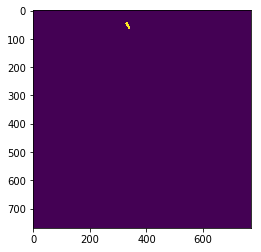

In [32]:
test_row = filtered_data.EncodedPixels.iloc[1]
print(test_row)
test_image = np.zeros((768, 768))
out_arr = code2image(test_row, test_image)
print(sum(sum(out_arr)))
plt.imshow(out_arr)
plt.show()

In [109]:
grouped_dat = filtered_data.groupby('ImageId')

In [50]:
import imageio

In [53]:
for group, rows in grouped_dat:
    
    image = np.zeros((768, 768))
    for index, row in rows.iterrows():
        image = code2image(row['EncodedPixels'], image)
    
    imageio.imwrite('../DeepBlueSea/data/train_maps/gt_'+group, 255*image)

/Users/brianregan/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/Users/brianregan/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


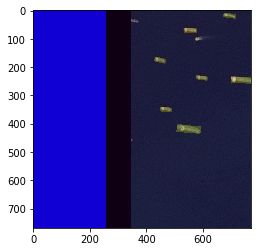

In [72]:
# View Some Examples 
name = '3c74edc8e.jpg'
train_image = imageio.imread('../DeepBlueSea/data/train_sample/' + name)
gt_map = image = imageio.imread('../DeepBlueSea/data/train_maps/gt_' + name)
plt.imshow(train_image)
plt.imshow(gt_map, alpha = 0.25)
plt.show()

In [103]:
def code2box(encoding, label):
    if pd.isnull(encoding):
        return [label,np.asarray([0,0]), 0, 0]
    else:
        split_encoding = encoding.split()
        n_pixels = int(len(split_encoding)/2)
        
        # pixels are 1 indexed in order 1: (1,1), 2: (2,1), etc. 
        # see: https://www.kaggle.com/c/airbus-ship-detection#evaluation
        input_image = np.zeros((768, 768))
        flatten_image = input_image.flatten('F')
        
        for pixel_idx in range(n_pixels):
            row_numb = int(split_encoding[pixel_idx*2])
            mask_len = int(split_encoding[pixel_idx*2 + 1])
            
            flatten_image[row_numb:row_numb+mask_len] = 1
        input_image = np.reshape(flatten_image, newshape = (768, 768), order='F')
        
        xaxis, yaxis = np.nonzero(input_image)
        corner = np.asarray([0,0])
        corner[0] = np.min(xaxis)
        corner[1] = np.min(yaxis)
        height = np.max(yaxis) - corner[1]
        width = np.max(xaxis) - corner[0]
        if width == 767:
            # understand where the pb is
            if len(xaxis[xaxis==np.min(xaxis)+1]) == 0:
                xaxis = xaxis[xaxis>np.min(xaxis)]
            elif len(xaxis[xaxis==np.max(xaxis)-1]) == 0:
                xaxis = xaxis[xaxis<np.max(xaxis)]
            else:
                print("Problem!")
            corner[0] = np.min(xaxis)
            width = np.max(xaxis) - corner[0]
        return [label, corner, width, height]

In [106]:
#output = np.empty((len(all_labels),2))
output = [code2box(row['EncodedPixels'],row['ImageId']) for index, row in all_labels.iterrows()]
#df = all_labels.head(5)
#output = [ code2box(row['EncodedPixels'],row['ImageId']) for index, row in df.iterrows()]

In [109]:
df_out = pd.DataFrame(output, columns=['ImageId','corner', 'width', 'height'])

In [111]:
df_out.head()

,ImageId,corner,width,height
0,00003e153.jpg,"[0, 0]",0,0
1,0001124c7.jpg,"[0, 0]",0,0
2,000155de5.jpg,"[466, 344]",35,103
3,000194a2d.jpg,"[288, 469]",19,22
4,000194a2d.jpg,"[378, 67]",8,17


In [112]:
df_out.head()
path = "/Users/margheritarosnati/Documents/DS/2018-2/DL/DeepBlueSea/data/train_maps/boxes.pkl"
df_out.to_pickle(path)

## test

In [57]:
path = "/Users/margheritarosnati/Documents/DS/2018-2/DL/DeepBlueSea/data/train_maps/boxes.pkl"
df = pd.read_pickle(path)
df.head(2)

,ImageId,corner,width,height
0,00003e153.jpg,"[0, 0]",0,0
1,0001124c7.jpg,"[0, 0]",0,0


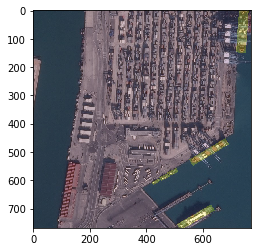

            ImageId                                      EncodedPixels
9180  0a148697c.jpg  363835 2 364603 4 365370 5 366138 6 366905 9 3...
9181  0a148697c.jpg  549261 8 550014 23 550768 37 551521 52 552274 ...
9182  0a148697c.jpg  342349 2 343117 4 343884 7 344652 9 345419 12 ...
9183  0a148697c.jpg  390130 1 390897 4 391665 6 392432 9 393200 10 ...
9184  0a148697c.jpg  321632 1 322399 4 323167 6 323934 8 324702 10 ...
9185  0a148697c.jpg  422927 1 423694 4 424462 6 425229 8 425997 10 ...


,ImageId,corner,width,height
9180,0a148697c.jpg,"[557, 473]",26,38
9181,0a148697c.jpg,"[1, 715]",150,44
9182,0a148697c.jpg,"[575, 445]",26,36
9183,0a148697c.jpg,"[0, 507]",767,132
9184,0a148697c.jpg,"[593, 418]",23,30
9185,0a148697c.jpg,"[451, 550]",97,140


In [59]:
name = '0a148697c.jpg'
train_image = imageio.imread('../data/train_sample/' + name)
plt.imshow(train_image)
gt_map = imageio.imread('../data/train_maps/gt_' + name)
plt.imshow(train_image)
plt.imshow(gt_map, alpha = 0.25)
plt.show()
print(all_labels[all_labels.ImageId==name])
df[df.ImageId==name]

In [108]:
print(len(df[df.width>700]),len(df[df.width==767]))
"""
i=3
test_row = all_labels[all_labels.ImageId==name].EncodedPixels.iloc[i]
test_image = np.zeros((768, 768))
out_arr = code2box(test_row, test_image)
out_arr"""

1371 1371


'\ni=3\ntest_row = all_labels[all_labels.ImageId==name].EncodedPixels.iloc[i]\ntest_image = np.zeros((768, 768))\nout_arr = code2box(test_row, test_image)\nout_arr'

[  0   0   0 ... 767 767 767] [516 517 518 ... 531 532 533]
[array([684, 507]), 82, 132]


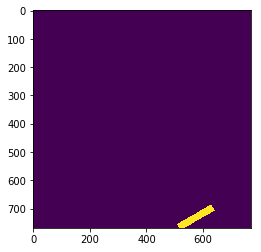

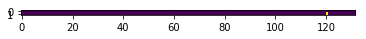

In [79]:
i=3
test_row = all_labels[all_labels.ImageId==name].EncodedPixels.iloc[i]
test_image = np.zeros((768, 768))
out_arr = code2image(test_row, test_image)
#### Full algo
encoding = test_row
input_image = test_image
####
split_encoding = encoding.split()
n_pixels = int(len(split_encoding)/2)

# pixels are 1 indexed in order 1: (1,1), 2: (2,1), etc. 
# see: https://www.kaggle.com/c/airbus-ship-detection#evaluation
input_image = np.zeros((768, 768))
flatten_image = input_image.flatten('F')

for pixel_idx in range(n_pixels):
    row_numb = int(split_encoding[pixel_idx*2])
    mask_len = int(split_encoding[pixel_idx*2 + 1])

    flatten_image[row_numb:row_numb+mask_len] = 1
input_image = np.reshape(flatten_image, newshape = (768, 768), order='F')
xaxis, yaxis = np.nonzero(input_image)
print(xaxis,yaxis)
corner = np.asarray([0,0])
corner[0] = np.min(xaxis)
corner[1] = np.min(yaxis)
height = np.max(yaxis) - corner[1]
width = np.max(xaxis) - corner[0]
####
####
print(code2box(test_row, test_image)[1:])
corner, width, height = code2box(test_row, test_image)[1:]
plt.imshow(out_arr)
plt.show()
#plt.imshow(out_arr[corner[0]:corner[0]+width,corner[1]:corner[1]+height])
plt.imshow(out_arr[corner[0]:corner[0]+2,corner[1]:corner[1]+height])
plt.show()

[  0   0   0 ... 767 767 767] [725 726 727 ... 757 758 759]
[array([  0, 715]), 767, 44]


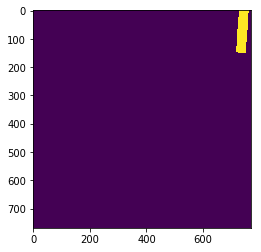

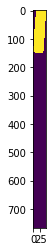

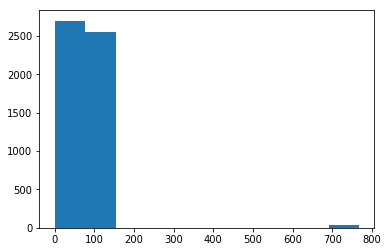

In [88]:
i=1
test_row = all_labels[all_labels.ImageId==name].EncodedPixels.iloc[i]
test_image = np.zeros((768, 768))
out_arr = code2image(test_row, test_image)
#### Full algo
encoding = test_row
input_image = test_image
####
split_encoding = encoding.split()
n_pixels = int(len(split_encoding)/2)

# pixels are 1 indexed in order 1: (1,1), 2: (2,1), etc. 
# see: https://www.kaggle.com/c/airbus-ship-detection#evaluation
input_image = np.zeros((768, 768))
flatten_image = input_image.flatten('F')

for pixel_idx in range(n_pixels):
    row_numb = int(split_encoding[pixel_idx*2])
    mask_len = int(split_encoding[pixel_idx*2 + 1])

    flatten_image[row_numb:row_numb+mask_len] = 1
input_image = np.reshape(flatten_image, newshape = (768, 768), order='F')
# found some flaw for the top line
temp = input_image[0,:]
shape = input_image.shape
input_image[0:shape[0]-2,:] = input_image[1:shape[0]-1,:]
input_image[-1,:] = temp
xaxis, yaxis = np.nonzero(input_image)
print(xaxis,yaxis)
corner = np.asarray([0,0])
corner[0] = np.min(xaxis)
corner[1] = np.min(yaxis)
height = np.max(yaxis) - corner[1]
width = np.max(xaxis) - corner[0]
####
####
print(code2box(test_row, test_image)[1:])
corner, width, height = code2box(test_row, test_image)[1:]
plt.imshow(out_arr)
plt.show()
plt.imshow(out_arr[corner[0]:corner[0]+width,corner[1]:corner[1]+height])
#plt.imshow(out_arr[corner[0]+width-2:corner[0]+width,corner[1]:corner[1]+height])
plt.show()
plt.hist(xaxis)
plt.show()

# --------------------------------------------------------------------------------

# 0-1 booleans

In [25]:
imgs_0 = np.array(all_labels[all_labels.EncodedPixels.isnull()==1].ImageId)
imgs_1_all = np.array(all_labels[all_labels.EncodedPixels.isnull()==0].ImageId)
imgs_1 = np.unique(imgs_1_all)

In [39]:
imgs_0 = np.reshape(imgs_0, (imgs_0.shape[0],1))
imgs_1 = np.reshape(imgs_1, (imgs_1.shape[0],1))
imgs_0.shape, imgs_1.shape

((150000, 1), (42556, 1))

In [42]:
zeros = np.concatenate((imgs_0, np.zeros(imgs_0.shape)),axis=1)
ones =  np.concatenate((imgs_1, np.ones(imgs_1.shape)),axis=1)
all_ims = np.concatenate((zeros,ones), axis=0)

In [48]:
np.unique(np.array(all_labels.ImageId)).shape, all_ims.shape

((192556,), (192556, 2))

In [47]:
df_has_boat = pd.DataFrame(all_ims, columns=['ImageId','Img_contains_boat'])

In [50]:
df_has_boat[df_has_boat.Img_contains_boat==1].head()

,ImageId,Img_contains_boat
150000,000155de5.jpg,1
150001,000194a2d.jpg,1
150002,00021ddc3.jpg,1
150003,0002756f7.jpg,1
150004,00031f145.jpg,1


In [51]:
path = "/Users/margheritarosnati/Documents/DS/2018-2/DL/DeepBlueSea/data/train_maps/img_has_boat.csv"
df_has_boat.to_csv(path)